In [1]:
import os
import time
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import numpy as np
from PIL import Image

from sklearn.metrics import jaccard_score
from medpy.metric.binary import hd, asd 

import ssl

/home/davi/projects/TI0160-visao-computacional/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
os.chdir("..")

In [40]:
ssl._create_default_https_context = ssl._create_unverified_context

PATCH_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
N_EPOCHS = 30
N_WORKERS = 10
MODELS_PATH = "models/segmentation"
REPORTS_PATH = "reports/figures/segmentation"

In [ ]:
class Covid19Dataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        """
        image_paths: Lista de caminhos das imagens.
        mask_paths: Lista de caminhos das máscaras correspondentes.
        """
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(PATCH_SIZE),
                torchvision.transforms.ToTensor(),
            ]
        )
        self.image_paths = image_paths
        self.mask_paths = mask_paths


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask


In [6]:
from sklearn.model_selection import train_test_split

root_dir = "data/raw"

all_image_paths = []
all_mask_paths = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    if os.path.isdir(class_dir):
        image_dir = os.path.join(class_dir, "images")
        mask_dir = os.path.join(class_dir, "masks")

        img_names = sorted(os.listdir(image_dir))

        for img_name in img_names[:250]:
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)
            all_image_paths.append(img_path)
            all_mask_paths.append(mask_path)

train_images, test_images, train_masks, test_masks = train_test_split(
    all_image_paths, all_mask_paths, test_size=0.2, random_state=42
)


In [7]:
test_dataset = Covid19Dataset(test_images, test_masks)

In [23]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    num_workers=N_WORKERS
)
test_images_data = next(iter(test_loader))

In [16]:
import matplotlib.pyplot as plt
import torch
import os
import segmentation_models_pytorch as smp

def load_model(model_path):
    basename = os.path.basename(model_path)
    encoder_name = basename.split('_unet_model')[0]
    
    encoder_weights = "imagenet+background" if encoder_name == "inceptionv4" else "imagenet"
    
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=1,
        classes=1,
    ).to(DEVICE)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()

    return encoder_name, model

In [ ]:
def dice_coefficient(pred, target):
    smooth = 1e-6  # Para evitar divisão por zero
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def jaccard_index(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    return jaccard_score(target, pred)

def hausdorff_distance(pred, target):
    pred_np = pred.cpu().numpy().astype(bool)
    target_np = target.cpu().numpy().astype(bool)

    return hd(pred_np, target_np)

def average_surface_distance(pred, target):
    pred_np = pred.cpu().numpy().astype(bool)
    target_np = target.cpu().numpy().astype(bool)
    return asd(pred_np, target_np)

def evaluate(model, loader):
    model.eval()
    dice_scores = []
    jaccard_scores = []
    hausdorff_distances = []
    avg_surface_distances = []
    times = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                pred = preds[i].cpu()
                mask = masks[i].cpu()

                dice = dice_coefficient(pred, mask)
                dice_scores.append(dice)

                jaccard = jaccard_index(pred, mask)
                jaccard_scores.append(jaccard)

                hausdorff = hausdorff_distance(pred, mask)
                hausdorff_distances.append(hausdorff)

                avg_surf_dist = average_surface_distance(pred, mask)
                avg_surface_distances.append(avg_surf_dist)

            times.append(end_time - start_time)

    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)
    avg_hausdorff = np.mean(hausdorff_distances)
    avg_asd = np.mean(avg_surface_distances)
    mean_time = np.mean(times)
    
    return {
        "dice": avg_dice,
        "jaccard": avg_jaccard,
        "hausdorff": avg_hausdorff,
        "avg": avg_asd,
        "processing_time": mean_time
    }


In [17]:
model_dir = 'models/segmentation'
models = {}

for model_file in os.listdir(model_dir):
    model_path = os.path.join(model_dir, model_file)
    print(f"Carregando modelo: {model_file}")
    encoder_name, model = load_model(model_path)
    models[encoder_name] = model

Carregando modelo: resnet152_unet_model.pth


/tmp/ipykernel_2306/2289397099.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Carregando modelo: mobilenet_v2_unet_model.pth
Carregando modelo: vgg19_unet_model.pth
Carregando modelo: xception_unet_model.pth
Carregando modelo: inceptionv4_unet_model.pth
Carregando modelo: densenet201_unet_model.pth


In [48]:
results = {}
for model_name, model in models.items():
    metrics = evaluate(model, test_loader)
    results[model_name] = metrics

In [70]:
for model_name, result in results.items():
    print(f"{model_name} & {result['dice']:.2f} & {result['jaccard']:.2f} & {result['hausdorff']:.2f} & {result['avg']:.2f} & {int(result['processing_time'] * 1000)} \\\\")

resnet152 & 0.98 & 0.97 & 5.65 & 0.03 & 18 \\
mobilenet_v2 & 0.98 & 0.95 & 10.24 & 0.10 & 7 \\
vgg19 & 0.98 & 0.97 & 7.00 & 0.05 & 3 \\
xception & 0.98 & 0.96 & 8.96 & 0.10 & 7 \\
inceptionv4 & 0.98 & 0.96 & 7.79 & 0.07 & 20 \\
densenet201 & 0.98 & 0.96 & 7.06 & 0.05 & 25 \\


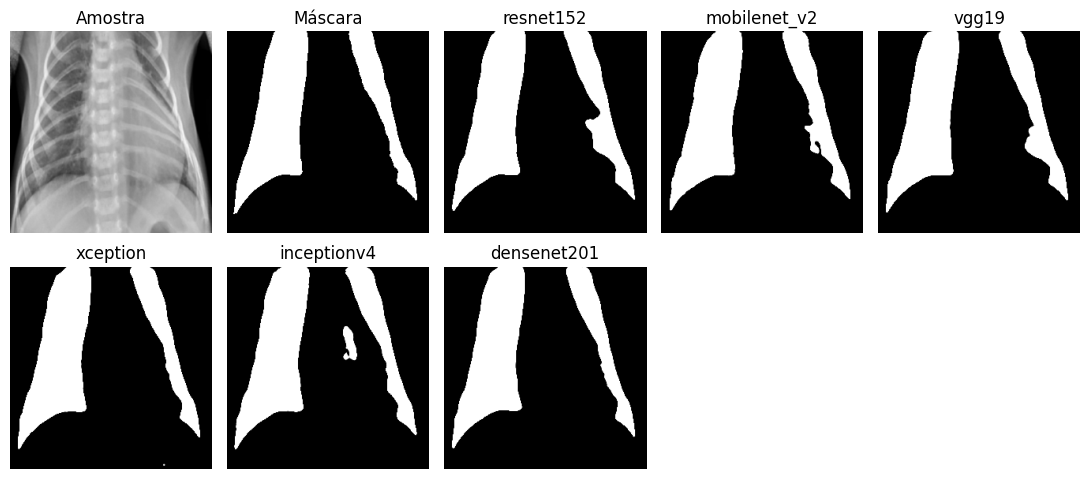

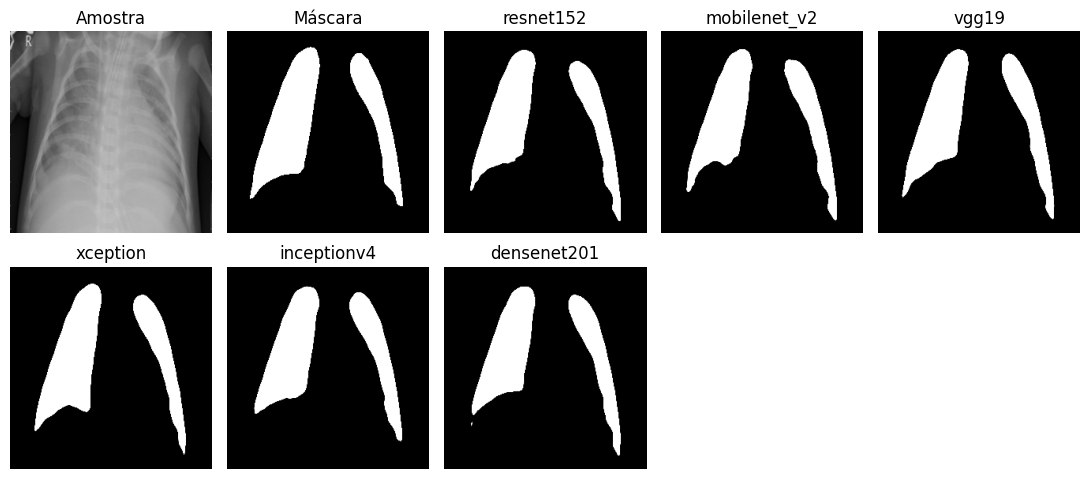

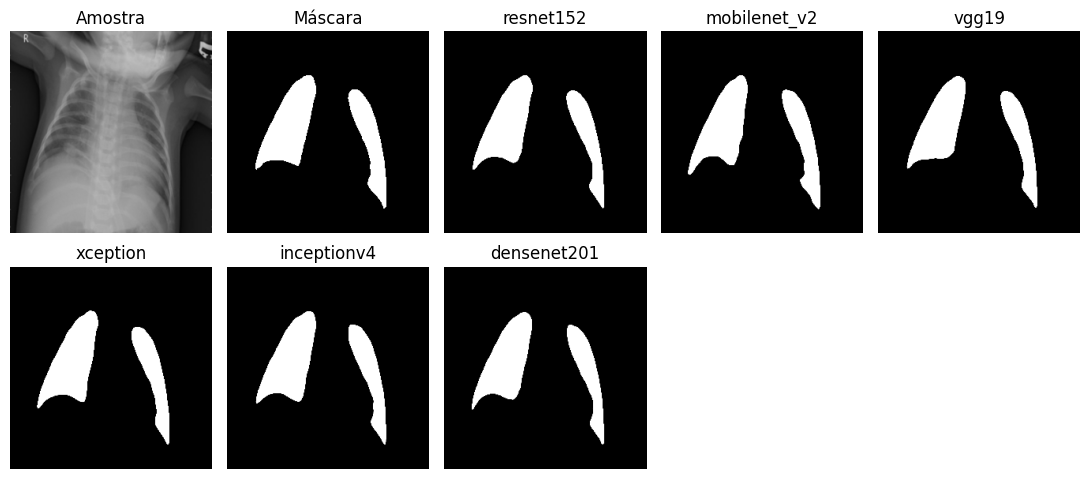

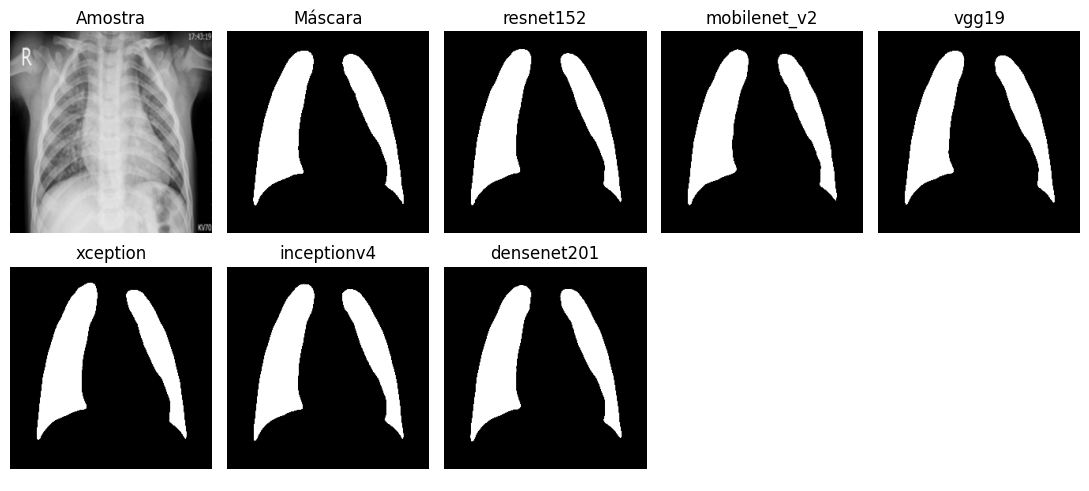

In [42]:
for index in range(4):
    image1 = Image.fromarray(test_images_data[0][index].numpy()[0] * 255)
    image2 = Image.fromarray(test_images_data[1][index].numpy()[0] * 255)

    fig, axes = plt.subplots(2, 5, figsize=(11, 5))

    axes[0, 0].imshow(image1)
    axes[0, 0].set_title("Amostra")

    axes[0, 1].imshow(image2)
    axes[0, 1].set_title("Máscara")

    for model_index, (model_name, model) in enumerate(models.items()):
        row = (model_index + 2) // 5
        column = (model_index + 2) % 5

        inputs, targets = test_images_data
        inputs, targets = inputs.to(DEVICE), targets.numpy()
        outputs = model(inputs)
        outputs = outputs.detach().cpu().numpy()
        model_image = Image.fromarray((outputs[index][0] * 255))

        axes[row, column].imshow(model_image)
        axes[row, column].set_title(model_name)

        for sub_axis in axes:
            for axis in sub_axis:
                axis.axis("off")

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(REPORTS_PATH, f"sample_{(index+1):02}"))